<a href="https://colab.research.google.com/github/berniwal/CIL_Project/blob/master/CIL-Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Go to correct directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.getcwd()
os.chdir('/content/drive/My Drive/CIL')
os.getcwd()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


'/content/drive/My Drive/CIL'

## install + import libraries

In [2]:
!pip install params_flow==0.7.1
!pip install py-params==0.7.3
!pip install sentencepiece
import sentencepiece as spm
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
from datetime import datetime

import bert
#different Tokenizer for Albert
from bert.tokenization.bert_tokenization import FullTokenizer
from bert.tokenization.albert_tokenization import AlbertFullTokenizer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert import BertModelLayer
import sentencepiece as spm

from tqdm import tqdm
import numpy as np

from sklearn.utils import shuffle

  Created wheel for params-flow: filename=params_flow-0.7.1-cp36-none-any.whl size=15376 sha256=4279260b02ee31eabf40300711c2b6b9d55d121f07ef4b86001d49a07f2869da
  Stored in directory: /root/.cache/pip/wheels/e2/7b/2a/b411aaa219132a68b17937fc9431fd9eb9c23c12a7df3d134f
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=86f1f3b4a0b0045074f0190793cfb361ced27463b10daf33747f3ed8b263baaf
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
Successfully built params-flow py-params
  Created wheel for py-params: filename=py_params-0.7.3-cp36-none-any.whl size=4346 sha256=86d8d8034582ef6e2776143df70ea64b1ef5ace60f0f851bce77cf19c34485f4
  Stored in directory: /root/.cache/pip/wheels/a3/9f/a1/e7e79bd92eecef952a46b16d0bc93ffdc91d4b619f79777d27
Successfully built py-params
  Found existing installation: py-params 0.9.7
    Uninstalling py-params-0.9.7:
      Successfully uninstalled py-params-0.9.7
     |██

INFO:tensorflow:Initializing the TPU system: grpc://10.35.217.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Fix Directories for BERT
First part of selecting which model

In [3]:
# 'bert' or 'bert_large' or 'albert'
MODEL = 'albert'
ADDITIONAL_DATA = False
ADDITIONAL_DATA_MIX = False
ADDITIONAL_DATA_ONLY_FIRST = False
identifier='large_albert' # for naming the output csv, weights and validation scores for graph

# '' or '_monoise' or '_monoise_b'
DATASET_PREPROCESSING = '' 

#Learning parameters
epochs = 6
start_epoch = 0
last_val_loss = None
patience = 5
no_improvement_since = 0
current_learning_rate = 1e-6
minimum_learning_rate = 1e-7
reload_training = True
reload_checkpoint = './albertlarge_albert_epoch_1.h5'
reload_epoch = 2
reload_learning_rate = 1e-6

CHECKPOINT = None
CHECKPOINT_CKPT = None
CHECKPOINT_VOCAB = None
CHECKPOINT_CONFIG = None

if MODEL == 'bert':
  CHECKPOINT = './bert/checkpoints/bert_base'
if MODEL == 'bert_large':
  CHECKPOINT = './bert/checkpoints/bert_large_wwm'
if MODEL == 'albert':
  CHECKPOINT = './bert/checkpoints/albert_xlarge'

if MODEL == 'bert' or MODEL == 'bert_large':
  CHECKPOINT_CKPT = os.path.join(CHECKPOINT, 'bert_model.ckpt')
  CHECKPOINT_VOCAB = os.path.join(CHECKPOINT, 'vocab.txt')
  CHECKPOINT_CONFIG = os.path.join(CHECKPOINT, 'bert_config.json')
if MODEL == 'albert':
  CHECKPOINT_VOCAB = os.path.join(CHECKPOINT, '30k-clean.model')
  CHECKPOINT_CKPT = os.path.join(CHECKPOINT, 'model.ckpt-best')
  CHECKPOINT_CONFIG = os.path.join(CHECKPOINT, 'albert_config.json')

DATASET_DIR = './'
DATASET_FILE_TRAIN_NEG = os.path.join(DATASET_DIR, 'twitter-datasets/train_neg_full{}.txt'.format(DATASET_PREPROCESSING))
DATASET_FILE_TRAIN_POS = os.path.join(DATASET_DIR, 'twitter-datasets/train_pos_full{}.txt'.format(DATASET_PREPROCESSING))
DATASET_FILE_TEST = os.path.join(DATASET_DIR, 'twitter-datasets/test_data{}.txt'.format(DATASET_PREPROCESSING))

DATASET_FILE_NEG_EXTRA = os.path.join(DATASET_DIR, 'twitter-datasets/extra_neg{}.txt'.format(DATASET_PREPROCESSING))
DATASET_FILE_POS_EXTRA = os.path.join(DATASET_DIR, 'twitter-datasets/extra_pos{}.txt'.format(DATASET_PREPROCESSING))

FILE_PATHS = [DATASET_FILE_TRAIN_POS, DATASET_FILE_TRAIN_NEG]

steps = None
if ADDITIONAL_DATA:
  steps = 336
else:
  steps = 200

## methods to create BERT layer
change name="albert" for other model, have to adjust paths above too

In [4]:
def flatten_layers(root_layer):
    if isinstance(root_layer, keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer


def freeze_bert_layers(l_bert):
    """
    Freezes all but LayerNorm and adapter layers - see arXiv:1902.00751.
    """
    for layer in flatten_layers(l_bert):
        if layer.name in ["LayerNorm", "adapter-down", "adapter-up"]:
            layer.trainable = True
        elif len(layer._layers) == 0:
            layer.trainable = False
        l_bert.embeddings_layer.trainable = False


def create_learning_rate(learn_rate=5e-5):

    def lr_scheduler(epoch):
        return float(learn_rate)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler

def create_learning_rate_scheduler(max_learn_rate=5e-5,
                                   end_learn_rate=1e-7,
                                   warmup_epoch_count=10,
                                   total_epoch_count=90):

    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            #res = (max_learn_rate/warmup_epoch_count) * (epoch + 1)
            res = end_learn_rate
        else:
            res = max_learn_rate*math.exp(math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler


def create_model(max_seq_len, adapter_size=64):
    """Creates a classification model."""

    # adapter_size = 64  # see - arXiv:1902.00751

    # create the bert layer
    with tf.io.gfile.GFile(CHECKPOINT_CONFIG, "r") as reader:
        #Download from Google
        #model_dir    = bert.fetch_tfhub_albert_model(model_name, ".models")
        #bert_params = bert.albert_params(model_name)
        #bert_l = BertModelLayer.from_params(bert_params, name="albert", shared_layer=True, embedding_size=128)
        
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = adapter_size
        bert_l = None
        if MODEL[:4] == 'bert':
          bert_l = BertModelLayer.from_params(bert_params, name="bert")
        else:
          bert_l = BertModelLayer.from_params(bert_params, name="albert", shared_layer=True, embedding_size=128)

    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
    # token_type_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="token_type_ids")
    # output         = bert([input_ids, token_type_ids])
    output = bert_l(input_ids)

    print("bert shape", output.shape)
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=2, activation="softmax")(logits)

    # model = keras.Model(inputs=[input_ids, token_type_ids], outputs=logits)
    # model.build(input_shape=[(None, max_seq_len), (None, max_seq_len)])
    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    # load the pre-trained model weights
    if MODEL[:4] == 'bert':
      load_stock_weights(bert_l, CHECKPOINT_CKPT)
    else:
      bert.load_albert_weights(bert_l, CHECKPOINT_CKPT)

    # freeze weights if adapter-BERT is used
    if adapter_size is not None:
        freeze_bert_layers(bert_l)

    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

    return model

# Define Dataloading Class
Also loading data into array


In [5]:
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

def load_data(file_path):
    data = {}
    data["sentence"] = []
    with open(file_path, "r") as f:
        data["sentence"] = f.readlines()

    #longest_string = max(data["sentence"], key=len)
    #print(longest_string)
    #print(len(longest_string))

    return pd.DataFrame.from_dict(data)

def load_dataset(pos_directory, neg_directory):
    pos_df = load_data(pos_directory)
    neg_df = load_data(neg_directory)

    pos_df["sentiment"] = 1
    neg_df["sentiment"] = 0

    return pd.concat([pos_df, neg_df])

class MovieReviewData:
    DATA_COLUMN = "sentence"
    LABEL_COLUMN = "sentiment"

    def __init__(self, tokenizer= FullTokenizer, max_seq_len=128, steps=200, extra_data=False):
        self.tokenizer = tokenizer
        self.step = None
        self.sample_size= 128*937
        self.max_seq_len = max_seq_len
        self.train_x = None
        self.train_x_token_types = None
        self.test_x = None
        self.test_x_token_types = None
        self.train_y = None
        self.test_y = None
        self.steps = steps
        self.extra_data = extra_data
        
    def _prepare(self, df):
        x, y = [], []
        with tqdm(total=df.shape[0], unit_scale=True) as pbar:
            for ndx, row in df.iterrows():
                text, label = row[MovieReviewData.DATA_COLUMN], row[MovieReviewData.LABEL_COLUMN]
                tokens = self.tokenizer.tokenize(text)
                tokens = ["[CLS]"] + tokens + ["[SEP]"]
                token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
                # self.max_seq_len = max(self.max_seq_len, len(token_ids))
                x.append(token_ids)
                y.append(int(label))
                pbar.update()
        return np.array(x), np.array(y)

    def _pad(self, ids):
        x, t = [], []
        token_type_ids = [0] * self.max_seq_len
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
            t.append(token_type_ids)
        return np.array(x), np.array(t)

    def load_data(self, step, update_test=True):
        trainset = load_dataset(DATASET_FILE_TRAIN_POS, DATASET_FILE_TRAIN_NEG)

        step = step % self.steps

        trainset = shuffle(trainset, random_state=5)
        #remove already processed data
        train = trainset.head(2400000)

        if self.extra_data:
          trainset_extra = load_dataset(DATASET_FILE_POS_EXTRA, DATASET_FILE_NEG_EXTRA)
          trainset_extra = shuffle(trainset_extra, random_state=5)
          
          if ADDITIONAL_DATA_ONLY_FIRST:
            train = pd.concat([trainset_extra, train], ignore_index=True)
          else:
            train = pd.concat([train, trainset_extra], ignore_index=True)

          if ADDITIONAL_DATA_MIX:
            train = shuffle(train)
        
        train = train.head(self.steps*128*93)
        train = train.tail(self.steps*128*93 - step*128*93)
        train = train.head(128*93)
        test = trainset.tail(100000)
        #train = trainset.head(10*128)
        #test = trainset.tail(10*128)

        train = shuffle(train)
        test = shuffle(test)

        train.reset_index(inplace=True, drop=True)
        test.reset_index(inplace=True, drop=True)

        if update_test:
          ((self.train_x, self.train_y),
          (self.test_x, self.test_y)) = map(self._prepare, [train, test])

          ((self.train_x, self.train_x_token_types),
          (self.test_x, self.test_x_token_types)) = map(self._pad,
                                                        [self.train_x, self.test_x])
        else:
          df_empty = pd.DataFrame({'empty' : []})
          ((self.train_x, self.train_y),
          (_, _)) = map(self._prepare, [train, df_empty])

          ((self.train_x, self.train_x_token_types),
          (_, _)) = map(self._pad, [self.train_x, []])

spm_model = None
sp = None

if MODEL == 'albert':
  spm_model = os.path.join('./bert/checkpoints/albert_xlarge/', "30k-clean.model")
  sp = spm.SentencePieceProcessor()
  sp.load(spm_model)

tokenizer = None
if MODEL[:4] == 'bert':
  tokenizer = FullTokenizer(vocab_file=CHECKPOINT_VOCAB, do_lower_case=True)
else:
  tokenizer = AlbertFullTokenizer(vocab_file=None, do_lower_case=True, spm_model_file=CHECKPOINT_VOCAB)

## BERT text preprocessing

In [6]:
def pre_process_positive(x, max_seq_len):
  tokens = tokenizer.tokenize(x.numpy())
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  token_ids = token_ids[:min(len(token_ids), max_seq_len - 2)]
  token_ids = np.concatenate((token_ids, np.zeros((max_seq_len - len(token_ids))))).astype(np.int32)
  return token_ids, int(1)

def pre_process_negative(x, max_seq_len):
  tokens = tokenizer.tokenize(x.numpy())
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  token_ids = token_ids[:min(len(token_ids), max_seq_len - 2)]
  token_ids = np.concatenate((token_ids, np.zeros((max_seq_len - len(token_ids))))).astype(np.int32)
  return token_ids, int(0)

def pre_process_text(x):
  tokens = tokenizer.tokenize(x.numpy())
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  return tokens

def dummy_pre_process(x):
   return tf.constant(3, shape=(128,))

## Build Model

In [7]:
max_seq_len = 128
adapter_size = None

with tpu_strategy.scope():
    model = create_model(max_seq_len, adapter_size=adapter_size)

model.summary()

total_epoch_count = 1

bert shape (None, 128, 2048)
Loading google-research/ALBERT weights...
Done loading 22 BERT weights from: ./bert/checkpoints/albert_xlarge/model.ckpt-best into <bert.model.BertModelLayer object at 0x7fbd2f3b9ba8> (prefix:albert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
	global_step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
____________________________________________________________


## Train model/fit+save weights

In [ ]:
data = MovieReviewData(tokenizer, max_seq_len=128, steps=steps, extra_data=ADDITIONAL_DATA)

val_losses = []
val_accuracy = []
train_losses = []
train_accuracy = []

if reload_training:
  model.load_weights(reload_checkpoint)
  start_epoch = reload_epoch
  current_learning_rate = reload_learning_rate
  if ADDITIONAL_DATA_ONLY_FIRST and start_epoch != 0:
    patience = 5
    steps = 200
    data = MovieReviewData(tokenizer, max_seq_len=128, steps=steps, extra_data=False)

finished_learning = False
update_test = True
for epoch in range(start_epoch, epochs):
  if epoch == 1 and ADDITIONAL_DATA and ADDITIONAL_DATA_ONLY_FIRST:
    steps = 200
    patience = 5
    no_improvement_since = 0
    data = MovieReviewData(tokenizer, max_seq_len=128, steps=steps, extra_data=False)
    update_test = True
  for step in range(steps):
    print('Epoch {}/{} Step {}/{}'.format(epoch, epochs-1, step, steps-1))
    print('Loading Data...')
    data.load_data(step, update_test)
    if update_test:
      update_test = False

    dataset_train = tf.data.Dataset.from_tensor_slices((data.train_x, data.train_y))
    dataset_train = dataset_train.batch(32, drop_remainder=True)

    dataset_test = tf.data.Dataset.from_tensor_slices((data.test_x, data.test_y))
    dataset_test = dataset_test.batch(32, drop_remainder=True)

    train_history = model.fit(dataset_train,
                    epochs=1,
                    callbacks=[create_learning_rate(learn_rate=current_learning_rate)])
    
    loss = train_history.history['loss'][0]
    accuracy = train_history.history['acc'][0]

    train_losses.append(loss)
    train_accuracy.append(accuracy)

    if step % 10 == 0:
      print('Run Validation...')
      results = model.evaluate(dataset_test)
      val_loss = results[0]
      val_acc = results[1]
      val_losses.append(val_loss)
      val_accuracy.append(val_acc)

      if last_val_loss is None or last_val_loss > val_loss:
        last_val_loss = val_loss
        no_improvement_since = 0
      else:
        no_improvement_since += 1
        if no_improvement_since >= patience:
          current_learning_rate = current_learning_rate * 0.1
          if current_learning_rate < minimum_learning_rate:
            print('Learning Finished Early')
            finished_learning = True
            break
          print('Decreasing Learning Rate to: {}'.format(current_learning_rate))
          no_improvement_since = 0
        else:
          print('No improvement since: {}'.format(no_improvement_since))


    if step != 0 and step % 100 == 0:
      model.save_weights('./'+MODEL+identifier+'_epoch_{}_step_{}.h5'.format(epoch, step), overwrite=True)

  model.save_weights('./'+MODEL+identifier+'_epoch_{}.h5'.format(epoch), overwrite=True)
  
  # Write Results Intermediate
  if not os.path.exists('./results'):
    os.mkdir('./results')

  f = open('./results/'+MODEL+identifier+'_epoch_{}_train.txt'.format(epoch), 'w')
  for x in range(len(train_losses)):
    f.write('{} {} {}\n'.format(x, train_losses[x], train_accuracy[x]))
  f.close()

  f = open('./results/'+MODEL+identifier+'_epoch_{}_validation.txt'.format(epoch), 'w')
  for x in range(len(val_losses)):
    f.write('{} {} {}\n'.format(x * 100, val_losses[x], val_accuracy[x]))
  f.close()

  if finished_learning: 
    break

model.save_weights('./'+MODEL+identifier+'.h5', overwrite=True)

# Write Results
if not os.path.exists('./results'):
  os.mkdir('./results')

f = open('./results/'+MODEL+identifier+'_train.txt', 'w')
for x in range(len(train_losses)):
  f.write('{} {} {}\n'.format(x, train_losses[x], train_accuracy[x]))
f.close()

f = open('./results/'+MODEL+identifier+'_validation.txt', 'w')
for x in range(len(val_losses)):
  f.write('{} {} {}\n'.format(x * 100, val_losses[x], val_accuracy[x]))
f.close()

Epoch 2/5 Step 0/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:04<00:00, 2.77kit/s]
100%|██████████| 100k/100k [00:32<00:00, 3.09kit/s] 



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 231ms/step - loss: 0.4066 - acc: 0.9028 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 240s 77ms/step - loss: 0.4104 - acc: 0.8985
Epoch 2/5 Step 1/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.08kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4058 - acc: 0.9028 - lr: 1.0000e-06
Epoch 2/5 Step 2/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.56kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4031 - acc: 0.9051 - lr: 1.0000e-06
Epoch 2/5 Step 3/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.91kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 87s 233ms/step - loss: 0.4066 - acc: 0.9026 - lr: 1.0000e-06
Epoch 2/5 Step 4/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.87kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4054 - acc: 0.9019 - lr: 1.0000e-06
Epoch 2/5 Step 5/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 3.99kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4061 - acc: 0.9033 - lr: 1.0000e-06
Epoch 2/5 Step 6/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 3.97kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4007 - acc: 0.9099 - lr: 1.0000e-06
Epoch 2/5 Step 7/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.75kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4000 - acc: 0.9099 - lr: 1.0000e-06
Epoch 2/5 Step 8/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 3.99kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4029 - acc: 0.9065 - lr: 1.0000e-06
Epoch 2/5 Step 9/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.79kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4075 - acc: 0.9024 - lr: 1.0000e-06
Epoch 2/5 Step 10/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.12kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4050 - acc: 0.9038 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 240s 77ms/step - loss: 0.4106 - acc: 0.8973
No improvement since: 1
Epoch 2/5 Step 11/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.91kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4076 - acc: 0.9008 - lr: 1.0000e-06
Epoch 2/5 Step 12/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.94kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4070 - acc: 0.9020 - lr: 1.0000e-06
Epoch 2/5 Step 13/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.18kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4039 - acc: 0.9056 - lr: 1.0000e-06
Epoch 2/5 Step 14/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.04kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.3996 - acc: 0.9088 - lr: 1.0000e-06
Epoch 2/5 Step 15/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.15kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4022 - acc: 0.9073 - lr: 1.0000e-06
Epoch 2/5 Step 16/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.06kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4046 - acc: 0.9057 - lr: 1.0000e-06
Epoch 2/5 Step 17/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4051 - acc: 0.9036 - lr: 1.0000e-06
Epoch 2/5 Step 18/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.18kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4091 - acc: 0.8989 - lr: 1.0000e-06
Epoch 2/5 Step 19/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.15kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4087 - acc: 0.8994 - lr: 1.0000e-06
Epoch 2/5 Step 20/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4050 - acc: 0.9029 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 241s 77ms/step - loss: 0.4082 - acc: 0.9003
Epoch 2/5 Step 21/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.90kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4055 - acc: 0.9041 - lr: 1.0000e-06
Epoch 2/5 Step 22/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.00kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4042 - acc: 0.9046 - lr: 1.0000e-06
Epoch 2/5 Step 23/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.16kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4042 - acc: 0.9067 - lr: 1.0000e-06
Epoch 2/5 Step 24/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.18kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.3989 - acc: 0.9115 - lr: 1.0000e-06
Epoch 2/5 Step 25/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.77kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4023 - acc: 0.9068 - lr: 1.0000e-06
Epoch 2/5 Step 26/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.03kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4037 - acc: 0.9053 - lr: 1.0000e-06
Epoch 2/5 Step 27/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.23kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4042 - acc: 0.9047 - lr: 1.0000e-06
Epoch 2/5 Step 28/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.05kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.3999 - acc: 0.9092 - lr: 1.0000e-06
Epoch 2/5 Step 29/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.11kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4024 - acc: 0.9062 - lr: 1.0000e-06
Epoch 2/5 Step 30/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.97kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 87s 233ms/step - loss: 0.4049 - acc: 0.9041 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 242s 77ms/step - loss: 0.4091 - acc: 0.8995
No improvement since: 1
Epoch 2/5 Step 31/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.79kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4067 - acc: 0.9036 - lr: 1.0000e-06
Epoch 2/5 Step 32/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.17kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4023 - acc: 0.9078 - lr: 1.0000e-06
Epoch 2/5 Step 33/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.10kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4049 - acc: 0.9045 - lr: 1.0000e-06
Epoch 2/5 Step 34/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.18kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4039 - acc: 0.9052 - lr: 1.0000e-06
Epoch 2/5 Step 35/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 231ms/step - loss: 0.4040 - acc: 0.9060 - lr: 1.0000e-06
Epoch 2/5 Step 36/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.29kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 231ms/step - loss: 0.4016 - acc: 0.9078 - lr: 1.0000e-06
Epoch 2/5 Step 37/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4030 - acc: 0.9052 - lr: 1.0000e-06
Epoch 2/5 Step 38/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4049 - acc: 0.9032 - lr: 1.0000e-06
Epoch 2/5 Step 39/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.15kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 231ms/step - loss: 0.4031 - acc: 0.9058 - lr: 1.0000e-06
Epoch 2/5 Step 40/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4026 - acc: 0.9068 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 240s 77ms/step - loss: 0.4086 - acc: 0.8998
No improvement since: 2
Epoch 2/5 Step 41/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4011 - acc: 0.9063 - lr: 1.0000e-06
Epoch 2/5 Step 42/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.03kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4022 - acc: 0.9068 - lr: 1.0000e-06
Epoch 2/5 Step 43/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.88kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 87s 233ms/step - loss: 0.4026 - acc: 0.9060 - lr: 1.0000e-06
Epoch 2/5 Step 44/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.95kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4021 - acc: 0.9072 - lr: 1.0000e-06
Epoch 2/5 Step 45/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.54kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4036 - acc: 0.9042 - lr: 1.0000e-06
Epoch 2/5 Step 46/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.21kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4044 - acc: 0.9041 - lr: 1.0000e-06
Epoch 2/5 Step 47/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.3981 - acc: 0.9127 - lr: 1.0000e-06
Epoch 2/5 Step 48/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.92kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.3999 - acc: 0.9089 - lr: 1.0000e-06
Epoch 2/5 Step 49/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.16kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4027 - acc: 0.9066 - lr: 1.0000e-06
Epoch 2/5 Step 50/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.21kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4017 - acc: 0.9084 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 241s 77ms/step - loss: 0.4081 - acc: 0.9004
Epoch 2/5 Step 51/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.00kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4034 - acc: 0.9052 - lr: 1.0000e-06
Epoch 2/5 Step 52/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4011 - acc: 0.9097 - lr: 1.0000e-06
Epoch 2/5 Step 53/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4040 - acc: 0.9044 - lr: 1.0000e-06
Epoch 2/5 Step 54/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4072 - acc: 0.9003 - lr: 1.0000e-06
Epoch 2/5 Step 55/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:04<00:00, 2.74kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 87s 233ms/step - loss: 0.4051 - acc: 0.9045 - lr: 1.0000e-06
Epoch 2/5 Step 56/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 3.99kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4004 - acc: 0.9094 - lr: 1.0000e-06
Epoch 2/5 Step 57/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.81kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 87s 233ms/step - loss: 0.4033 - acc: 0.9054 - lr: 1.0000e-06
Epoch 2/5 Step 58/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.79kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.3989 - acc: 0.9103 - lr: 1.0000e-06
Epoch 2/5 Step 59/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.62kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4015 - acc: 0.9078 - lr: 1.0000e-06
Epoch 2/5 Step 60/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.18kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
372/372 [==============================] - 86s 232ms/step - loss: 0.4006 - acc: 0.9086 - lr: 1.0000e-06
Run Validation...
1364/3125 [============>.................] - ETA: 2:15 - loss: 0.4089 - acc: 0.9002

## Generate Plots

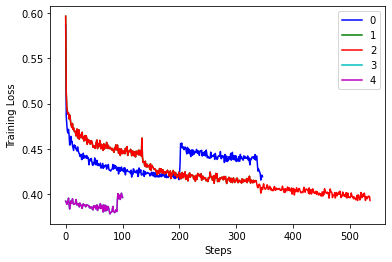

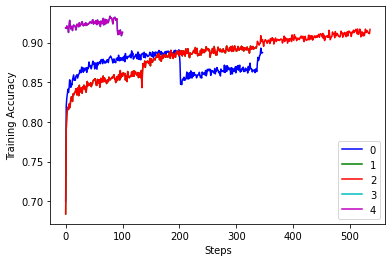

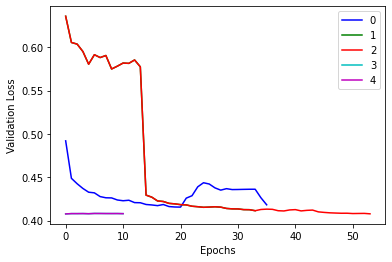

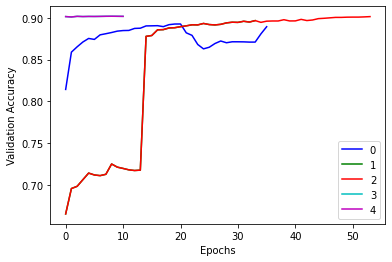

In [ ]:
# Code to generate Plots from File
import matplotlib.pyplot as plt

file_paths = os.listdir('./results/')
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

file_paths_train = [file_name for file_name in file_paths if 'train' in file_name]
file_paths_validation = [file_name for file_name in file_paths if 'validation' in file_name]

# Train Loss Accuracy Load Data
train_losses = []
train_accuracies = []
for file_index in range(min(len(file_paths_train), len(colors))):
  train_loss = []
  train_accuracy = []
  file_name = file_paths_train[file_index]
  f = open('./results/{}'.format(file_name))
  lines = f.readlines()
  for line in lines:
    step, current_loss, current_accuracy = line.split(' ')
    train_loss.append(float(current_loss))
    train_accuracy.append(float(current_accuracy))
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  
# Train Loss Plot Data
for idx, train_loss in enumerate(train_losses):
  plt.plot(train_loss, colors[idx], label=idx)

plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# Train Accuracy Plot Data
for idx, train_accuracy in enumerate(train_accuracies):
  plt.plot(train_accuracy, colors[idx], label=idx)

plt.xlabel('Steps')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

# Train Loss Accuracy Load Data
val_losses = []
val_accuracies = []
for file_index in range(min(len(file_paths_validation), len(colors))):
  val_loss = []
  val_accuracy = []
  file_name = file_paths_validation[file_index]
  f = open('./results/{}'.format(file_name))
  lines = f.readlines()
  for line in lines:
    step, current_loss, current_accuracy = line.split(' ')
    val_loss.append(float(current_loss))
    val_accuracy.append(float(current_accuracy))
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  
# Validation Loss Plot Data
for idx, val_loss in enumerate(val_losses):
  plt.plot(val_loss, colors[idx], label=idx)

plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Validation Accuracy Plot Data
for idx, val_accuracy in enumerate(val_accuracies):
  plt.plot(val_accuracy, colors[idx], label=idx)

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

# Check How Many Duplicated Sentences we have

In [ ]:
positive_data = []
with open(DATASET_FILE_TRAIN_POS, "r") as f:
  for x in f:
    positive_data.append(x)

negative_data = []
with open(DATASET_FILE_TRAIN_NEG, "r") as f:
  for x in f:
    negative_data.append(x)

print(len(positive_data))
positive_data = list(dict.fromkeys(positive_data))
print(len(positive_data))

print(len(negative_data))
negative_data = list(dict.fromkeys(negative_data))
print(len(negative_data))

1250000
1127644
1250000
1142838


## Preprocess test-set

In [ ]:
test_data = []
with open(DATASET_FILE_TEST, "r") as f:
  for x in f:
    test_data.append(x)

encoded_test_data = []
for x in test_data:
  result, _ = pre_process_positive(tf.convert_to_tensor(x), 128)
  encoded_test_data.append(tf.reshape(tf.convert_to_tensor(result), (1,128)))
encoded_test_ds = tf.data.Dataset.from_tensor_slices(encoded_test_data)

## Predict test set

In [ ]:
results = model.predict(encoded_test_ds)
labels = np.argmax(results, axis=1)

## Postprocessing

In [ ]:
labels = [1 if x == 1 else -1 for x in labels]

#reverse labels
# labels = [-1 if x == 1 else 1 for x in labels]
#un-reverse labels
# labels = [1 if x == -1 else -1 for x in labels]

In [ ]:
df = pd.DataFrame({'Id': np.arange(1,10001),
                  'Prediction': labels
                   })
df.to_csv(MODEL+identifier+'.csv', index=False)